<center><h1>Titanic data set: fitting a Random Forest model</h1><center>

In this notebook we will fit a random forest classifier to the Titanic data set, which we processed in the notebook "Titanic_exploratory.ipynb"

First we import the modules we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import SelectFromModel

from sklearn import preprocessing

from sklearn.metrics import classification_report

Read in the data we processed in titanic_exploratory


In [4]:
df_train = pd.read_csv("train_processed.csv")
df_test  = pd.read_csv("test_processed.csv")

Seperate out the labels

In [5]:
labels = df_train.Survived

All the remaining columns are features.

We will write a function that trains a model that is sent to it. 

This will split the labelled training data into train and test splits, scale all the data based on the train splot and then fit the model

The output will be the accuracy of the model on test splot, as well as the predictions for the unlabelled test data. 

The classification report will also be outputted, and we will write a second function to convert the outputted string into a data frame

In [6]:
#now to train it
def train_model(df, df_test, model, features, label, split=0.3):
    """function to learn from our data, print an estimate of the accuracy and output the predictions"""
    #make data into something that can be read by the model
    train_features = df[features].values.reshape(-1,len(features))
    train_label    = df[label].values.reshape(-1,)
    test_features  = df_test[features].values.reshape(-1,len(features))
    #split it into a training and a test set (split% to test)
    X_train, X_test, y_train, y_test = train_test_split(train_features, 
                                        train_label, test_size=split)
    #now we need to scale the data, such that they have mean 0 and variance 1
    std_scale = preprocessing.StandardScaler().fit(X_train) #do this on the training data
    X_train  = std_scale.transform(X_train)
    X_test  = std_scale.transform(X_test)
    test_features  = std_scale.transform(test_features)
    #fit the model
    model.fit(X_train, y_train)
    #now find the accuracy on the test set (make it into a percentage)
    acc_test = model.score(X_test, y_test)*100.0
    cls_report = classification_report(y_test, model.predict(X_test), target_names = ['Perished', 'Survived'])
    #and finally, make predictions on the unlabelled test data
    y_out = model.predict(test_features)
    return y_out, acc_test, cls_report

In [7]:
def classifaction_report_to_df(cls_report):
    """Function to convert a scikit_learn classification report from a string to a data frame"""
    data = []
    lines = cls_report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        data.append(row)    
    line=lines[-2]
    row = {}
    row_data = line.split('      ')
    row['class'] = row_data[0]
    row['precision'] = float(row_data[1])
    row['recall'] = float(row_data[2])
    row['f1_score'] = float(row_data[3])
    row['support'] = float(row_data[4])
    data.append(row)
    df = pd.DataFrame.from_dict(data)
    df = df.rename(index={0:'Perished', 1:'Survived', 2:'Avg'})
    df = df.drop('class', axis=1)
    #del df.index.name
    return df

First we fit a basic model:

We will begin with the random forest classifier to train the model, as it can help us to select good features to use

In [8]:
features = df_train.columns[df_train.columns != "Survived"].tolist()
rf = RandomForestClassifier()
res, acc_test, cls_report = train_model(df_train, df_test, rf, features, 'Survived', 0.3)
print('#accuracy from basic random forest (%)')
print('on test split    :', acc_test)
print('')
print('Classification report:')
print(classifaction_report_to_df(cls_report))

#accuracy from basic random forest (%)
on test split    : 83.2089552239

Classification report:
          f1_score  precision  recall  support
Perished      0.87       0.85    0.89    168.0
Survived      0.77       0.80    0.74    100.0
Avg           0.83       0.83    0.83    268.0


The precision (TP/(TP + FP): the number of correct positive guesses divided by the number of positive guesses we made) is very similar for both Survived and Perished

The recall (TP/(TP + FN): the number of correct positive guesses divided by the number that are actually positive) is somewhat smaller for those that survived. We are better at guessing if someone died than if they survived. This makes some sense, since we have more data for this (more people did not survive).

The random forest method also gives the importance of each of the features we used ...

In [9]:
#see what the important features are
importance = rf.feature_importances_
importance = pd.DataFrame(importance, index=features, columns=["Importance"])
importance.sort_values(by=['Importance'], ascending=False, inplace=True)
print(importance)

              Importance
Title           0.196293
Age_guess       0.152825
Fare            0.131896
Name_len        0.111554
Sex             0.107580
Name_cat        0.063141
Pclass          0.049551
Fam_type        0.039472
Cabin_letter    0.034669
SibSp           0.032376
Fam_size        0.028394
Embarked        0.022039
N_Cabins        0.016726
Parch           0.013482


The accuracy can change quite a bit between runs ....

In [10]:
features = df_train.columns[df_train.columns != "Survived"].tolist()
rf = RandomForestClassifier()
res, acc_test, cls_report = train_model(df_train, df_test, rf, features, 'Survived', 0.3)
print('#accuracy from basic random forest (%)') 
print('on test split    :', acc_test)
print('')
print('Classification report:')
print(classifaction_report_to_df(cls_report))

#accuracy from basic random forest (%)
on test split    : 79.8507462687

Classification report:
          f1_score  precision  recall  support
Perished      0.85       0.83    0.87    173.0
Survived      0.70       0.74    0.67     95.0
Avg           0.80       0.80    0.80    268.0


Note that the precision and recall are now also different, as is the "support" value (the number of data points we have for each class in our test split)

The importance of the features can also change

In [11]:
#see what the important features are
importance_2 = rf.feature_importances_
importance_2 = pd.DataFrame(importance_2, index=features, columns=["Importance (new)"])
importance_2 = pd.concat([importance_2, importance], axis=1, join='inner')
importance_2.sort_values(by=['Importance (new)'], ascending=False, inplace=True)
print(importance_2)

              Importance (new)  Importance
Title                 0.159255    0.196293
Fare                  0.153647    0.131896
Age_guess             0.153557    0.152825
Name_len              0.126985    0.111554
Sex                   0.125810    0.107580
Pclass                0.060426    0.049551
Fam_size              0.039047    0.028394
Cabin_letter          0.032080    0.034669
SibSp                 0.030394    0.032376
N_Cabins              0.029018    0.016726
Embarked              0.027860    0.022039
Fam_type              0.025355    0.039472
Parch                 0.019660    0.013482
Name_cat              0.016905    0.063141


Note that there are two resons why our results will differ.

Firstly, we make a new split of our labelled data each time we call our fitting function. For a small data set like the one we have here, this can lead to variation in results each time.

Secondly, using the random forest method means that even if we use the same split, we will get a different result each time we fit the model (since it is random, and hence non-deterministic).

We will explore the second point first. We can fit the model multiple times to a single split and examine the distribution of accuracies that we find.

In [12]:
#set the features
features = df_train.columns[df_train.columns != "Survived"].tolist()
#and the model
rf = RandomForestClassifier()
#how many times we fit the model
n_loop = 10000
#we will record the accuracy every time, so that we can plot it against the n_loop later
acc = np.empty(n_loop)
acc_av = np.empty(n_loop)
err_acc = np.empty(n_loop)
#and we will make an empty array for the feature importances
importance = np.empty([n_loop, len(features)])

#make the data into something that scikit learn can use
train_features = df_train[features].values.reshape(-1,len(features))
train_label    = df_train['Survived'].values.reshape(-1,)

#split it into a training and a test set (split% to test)
X_train, X_test, y_train, y_test = train_test_split(train_features, 
                                                    train_label,
                                                    test_size=0.3)
#now we need to scale the data, such that they have mean 0 and variance 1
std_scale = preprocessing.StandardScaler().fit(X_train) #do this on the training data
X_train  = std_scale.transform(X_train)
X_test  = std_scale.transform(X_test)

print('  i    acc     +/-')

for i in np.arange(0,n_loop):
    #fit the model
    rf.fit(X_train, y_train)
    #now find the accuracy on the test set (make it into a percentage)
    acc[i] = rf.score(X_test, y_test)*100.0
    acc_av[i] = acc[0:i+1].mean()
    if i > 0:
        err_acc[i] = acc[0:i+1].std()/np.sqrt(i)
    else:
        err_acc[i] = 0.0
    if np.remainder(i+1,n_loop/20) == 0:
        print('{0:5d}  {1:.3f}  {2:.3f}'.format(
            i+1, acc_av[i], err_acc[i]))


  i    acc     +/-
  500  80.734  0.059
 1000  80.721  0.044
 1500  80.692  0.036
 2000  80.680  0.032
 2500  80.703  0.028
 3000  80.693  0.026
 3500  80.703  0.024
 4000  80.713  0.022
 4500  80.719  0.021
 5000  80.725  0.020
 5500  80.724  0.019
 6000  80.722  0.018
 6500  80.724  0.017
 7000  80.723  0.017
 7500  80.725  0.016
 8000  80.726  0.016
 8500  80.719  0.015
 9000  80.717  0.015
 9500  80.719  0.014
10000  80.719  0.014


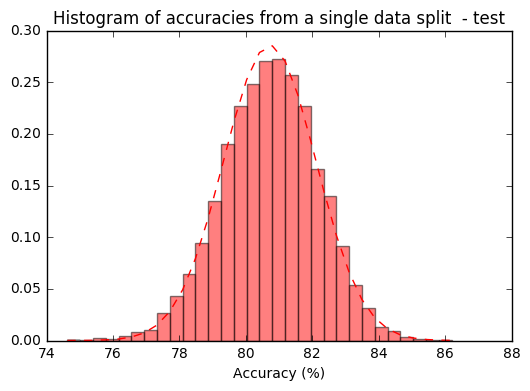

mean:      80.7189925373
s.d.:      1.39686046025


In [13]:
#plot the distribution of accuracies
n = np.int(np.floor(acc.max()/100.0*0.3*df_train.shape[0]-acc.min()/100.0*0.3*df_train.shape[0]))
mu = acc.mean()
sigma = acc.std()
n, bins, patches = plt.hist(acc,n, normed = 1,  color='red', alpha = 0.5)
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)
plt.title("Histogram of accuracies from a single data split  - test")
plt.xlabel("P(Acc)")
plt.xlabel("Accuracy (%)")
plt.show()
print('mean:     ', mu)
print('s.d.:     ', sigma)

The dashed line shows a Gaussian with the mean and standard deviation taken from the data, which describes well the accuracies for the test split. Note that the standard deviation of 1.42 is quite large: for this particular train-test split, we would expect to find an accuracy of between about 74.9% and 80.5% (two stds from the mean) 95% of the time. This is clearly a large variation.

We now return to the first point: we have a relatively small data set, and when we randomly split the data into the train and test sets, we will have a (somewhat) different distribution of e.g. ages, titles etc., and will get different results from each of these.

We will now fit to our data multiple times, using a new split for each fit.

In [14]:
#set the features
features = df_train.columns[df_train.columns != "Survived"].tolist()
#and the model
rf = RandomForestClassifier()
#how many times we fit the model
n_loop = 10000
#we will record the accuracy every time, so that we can plot it against the n_loop later
acc = np.empty(n_loop)
acc_av = np.empty(n_loop)
err_acc = np.empty(n_loop)
#and we will make an empty array for the feature importances
importance = np.empty([n_loop, len(features)])
#and we will sum up the predictions for the test set
res_sum = 0.0
cls_report_sum = pd.DataFrame({'f1_score' : [0,0,0], 'precision' : [0,0,0], 
                               'recall' : [0,0,0], 'support' : [0,0,0]}, 
                              index=['Perished', 'Survived', 'Avg'])
      
print('  i    acc     +/-')

for i in np.arange(0,n_loop):
    res, acc[i], cls_report = train_model(df_train, df_test, rf, features, 'Survived', 0.3)
    acc_av[i] = acc[0:i+1].mean()
    res_sum += res
    cls_report_sum += classifaction_report_to_df(cls_report)
    if i > 0:
        err_acc[i] = acc[0:i+1].std()/np.sqrt(i)
    else:
        err_acc[i] = 0.0
    importance[i,:] = rf.feature_importances_
    if np.remainder(i+1,n_loop/20) == 0:
        print('{0:5d}  {1:.3f}  {2:.3f}'.format(
            i+1, acc_av[i], err_acc[i]))
    
print('')
print('Classification report:')
print(cls_report_sum/float(n_loop))

  i    acc     +/-
  500  81.186  0.096
 1000  81.085  0.067
 1500  81.075  0.054
 2000  81.064  0.047
 2500  81.033  0.042
 3000  81.045  0.038
 3500  81.059  0.035
 4000  81.046  0.033
 4500  81.049  0.031
 5000  81.053  0.029
 5500  81.028  0.028
 6000  81.029  0.027
 6500  81.033  0.026
 7000  81.045  0.025
 7500  81.039  0.024
 8000  81.040  0.023
 8500  81.047  0.023
 9000  81.048  0.022
 9500  81.040  0.021
10000  81.032  0.021

Classification report:
          f1_score  precision    recall   support
Perished  0.851796   0.820454  0.886830  165.0615
Survived  0.735303   0.792097  0.688538  102.9385
Avg       0.807291   0.810501  0.810018  268.0000


We get an average accuracy of about 81%.

The precisions are, on average, relatively close (meaning that when we guess something, we guess it correctly with the same chance for both classes). The recall for Survived is lower than for Perished, so we are much better at predicting those that did not survived compared to those that did.

We now plot our results, showing the accuracy against the number of iterations, complete with error bars

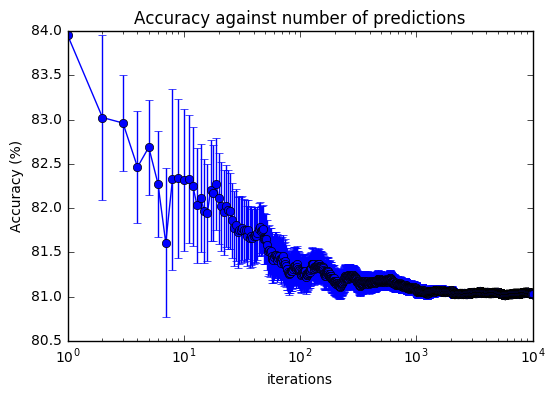

In [16]:
#plot the accuracy with error against the number of fits
plt.errorbar(np.arange(1, len(acc_av)+1), acc_av, 
                 yerr = err_acc, marker="o")
plt.title("Accuracy against number of predictions")
plt.xlabel("iterations")
plt.ylabel("Accuracy (%)")
plt.xscale('log')
plt.show()

Notice how it takes almost a thousand iterations before the accuracy of our predictions for the test split converges.

This way it superior to fitting to the same training split multiple times, as we will fit to all of the data over the multiple runs. Before, we simply found the same average accuracy for a particular split. While we could fit the model to each split multiple times and then sum up the averages for each split, this should be unnecessary as if we perform enough iterations it should all average out.

Now we want to output the results to submit to kaggle:

We'll write a function whereby we can send the results and the filename we want to use, and output it as a csv, eady to submit

In [17]:
def output_result(res, out_file):
    """output the results on the test set as a csv"""
    df_out = pd.DataFrame()
    df_out['PassengerId'] = range(892,892+len(res))
    df_out['Survived'] = res
    df_out[['PassengerId', 'Survived']].to_csv(out_file,  index = False)

In [18]:
out_file = "results.csv"
output_result(np.rint(res_sum/float(n_loop)).astype(int), out_file)

This scores 77.99%, about 3% below the accuracy found above

We can see how  this score (77.99%) compares to the distribution of accuracies we got from our test splits

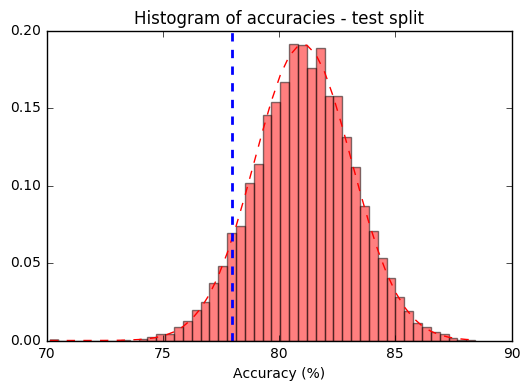

mean:      81.0315671642
s.d.:      2.08742918665
score:     77.99


In [19]:
#plot the distribution of accuracies
score = 77.99
#for the test split
n = np.int(np.floor(acc.max()/100.0*0.3*df_train.shape[0]-acc.min()/100.0*0.3*df_train.shape[0]))
mu = acc.mean()
sigma = acc.std()
n, bins, patches = plt.hist(acc,n, normed = 1,  color='red', alpha = 0.5)
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)
plt.axvline(score, color='b', linestyle='dashed', linewidth=2)
plt.title("Histogram of accuracies - test split")
plt.xlabel("P(Acc)")
plt.xlabel("Accuracy (%)")
plt.show()
print('mean:     ', mu)
print('s.d.:     ', sigma)
print('score:    ', score)


For the test split, we get good agreement with a Guassian with mean and std taken from the data. 

The standard deviation of about 2 means that 95% of the time we would expect accuracies in the range 77.1 - 85.4. The score we got submitting this to Kaggle falls within that range. 

Note that, while we have averaged our predictions of the 10,000 fits, the unlabelled test data is still a single sample, so we would not expect the results to be the same as above, but it does fall within our 95% confidence inteval.

We also calculated the average of the importances for each feature

In [20]:
#and output the average importances
df_importance = pd.DataFrame({'Importance':importance.mean(axis=0), 'error':importance.std(axis=0)/np.sqrt(n_loop)}, index=features)
df_importance.sort_values(by=['Importance'], ascending=False, inplace=True)
print(df_importance)

              Importance     error
Title           0.160838  0.000402
Age_guess       0.154018  0.000128
Fare            0.144018  0.000155
Name_len        0.134078  0.000150
Sex             0.115031  0.000372
Pclass          0.056018  0.000132
Cabin_letter    0.044962  0.000131
Fam_size        0.034301  0.000087
Name_cat        0.032384  0.000096
Fam_type        0.030757  0.000102
Embarked        0.028893  0.000053
N_Cabins        0.025735  0.000108
SibSp           0.022407  0.000063
Parch           0.016559  0.000040


Quite a few of these features give us similar information to other features (at least partly), so we will drop those with the lower score (or those with more catagories if they are close)
 - Title and Sex (drop Sex: sex is included in the title)
 - Name_len and Name_cat (drop Name_cat)
 - Fam_type, Fam_size, SibSp and Parch (drop the final three: Fam_type has 3 catagories and gets a similar score to the continuous Fam_size. SibSp and Parch are just summed to give Fam_size, so can also be dropped)
 - Fare and N_cabins are correlated, as is Fam_size and N_cabins, and we have much less data for N_Cabins, so we will drop that

In [21]:
df_train.drop('Sex', 1, inplace=True)
df_train.drop('Name_cat', 1, inplace=True)
df_train.drop('Parch', 1, inplace=True)
df_train.drop('SibSp', 1, inplace=True)
df_train.drop('Fam_size', 1, inplace=True)
df_train.drop('N_Cabins', 1, inplace=True)

df_test.drop('Sex', 1, inplace=True)
df_test.drop('Name_cat', 1, inplace=True)
df_test.drop('Parch', 1, inplace=True)
df_test.drop('SibSp', 1, inplace=True)
df_test.drop('Fam_size', 1, inplace=True)
df_test.drop('N_Cabins', 1, inplace=True)

Now we will repeat the fitting loop above and plot the results

In [22]:
#set the features
features = df_train.columns[df_train.columns != "Survived"].tolist()
#and the model
rf = RandomForestClassifier()
#how many times we fit the model
n_loop = 10000
#we will record the accuracy every time, so that we can plot it against the n_loop later
acc = np.empty(n_loop)
acc_av = np.empty(n_loop)
err_acc = np.empty(n_loop)
#and we will make an empty array for the feature importances
importance = np.empty([n_loop, len(features)])
#and we will sum up the predictions for the test set
res_sum = 0.0
cls_report_sum = pd.DataFrame({'f1_score' : [0,0,0], 'precision' : [0,0,0], 
                               'recall' : [0,0,0], 'support' : [0,0,0]}, 
                              index=['Perished', 'Survived', 'Avg'])
      
print('  i    acc     +/-')

for i in np.arange(0,n_loop):
    res, acc[i], cls_report = train_model(df_train, df_test, rf, features, 'Survived', 0.3)
    acc_av[i] = acc[0:i+1].mean()
    res_sum += res
    cls_report_sum += classifaction_report_to_df(cls_report)
    if i > 0:
        err_acc[i] = acc[0:i+1].std()/np.sqrt(i)
    else:
        err_acc[i] = 0.0
    importance[i,:] = rf.feature_importances_
    if np.remainder(i+1,n_loop/20) == 0:
        print('{0:5d}  {1:.3f}  {2:.3f}'.format(
            i+1, acc_av[i], err_acc[i]))
    
print('')
print('Classification report:')
print(cls_report_sum/float(n_loop))

  i    acc     +/-
  500  81.646  0.094
 1000  81.622  0.068
 1500  81.676  0.055
 2000  81.638  0.047
 2500  81.655  0.042
 3000  81.653  0.038
 3500  81.654  0.035
 4000  81.650  0.032
 4500  81.662  0.031
 5000  81.664  0.029
 5500  81.665  0.027
 6000  81.662  0.026
 6500  81.669  0.025
 7000  81.662  0.024
 7500  81.660  0.024
 8000  81.662  0.023
 8500  81.657  0.022
 9000  81.657  0.022
 9500  81.665  0.021
10000  81.663  0.020

Classification report:
          f1_score  precision    recall   support
Perished  0.856989   0.824539  0.893248  165.1994
Survived  0.743102   0.802607  0.694214  102.8006
Avg       0.813661   0.817002  0.816367  268.0000


We get about a 0.6% increase in the accuracy by removing the redundent features: quite a small gain, but we'll take it

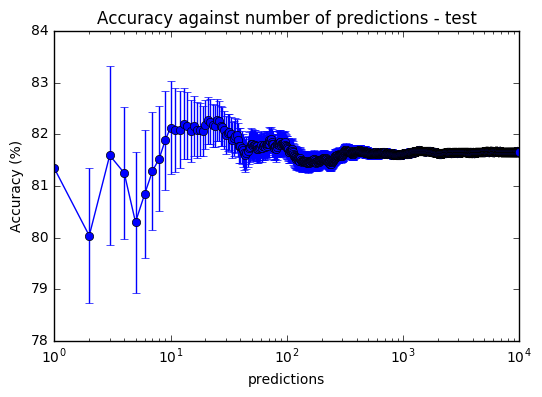

In [23]:
#plot the accuracy with error against the number of fits
plt.errorbar(np.arange(1, len(acc_av)+1), acc_av, 
                 yerr = err_acc, marker="o")
plt.title("Accuracy against number of predictions - test")
plt.xlabel("predictions")
plt.ylabel("Accuracy (%)")
plt.xscale('log')
plt.show()

In [29]:
out_file = "results.csv"
output_result(np.rint(res_sum/float(n_loop)).astype(int), out_file)

This time we scored 78.23%, so not as great an increase as we found for our test splits

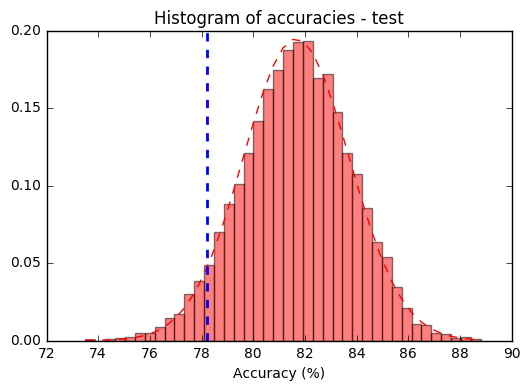

mean:      81.6630597015
s.d.:      2.04986127545
score:     78.23


In [30]:
#plot the distribution of accuracies
score = 78.23

n = np.int(np.floor(acc.max()/100.0*0.3*df_train.shape[0]-acc.min()/100.0*0.3*df_train.shape[0]))
mu = acc.mean()
sigma = acc.std()
#plt.hist(acc_av_r, normed = 1,  color='lightblue', alpha=0.5, label='r', bins=bins_r)
n, bins, patches = plt.hist(acc,n, normed = 1,  color='red', alpha = 0.5)
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)
plt.axvline(score, color='b', linestyle='dashed', linewidth=2)
plt.title("Histogram of accuracies - test")
plt.xlabel("P(Acc)")
plt.xlabel("Accuracy (%)")
plt.show()
print('mean:     ', mu)
print('s.d.:     ', sigma)
print('score:    ', score)

In [31]:
#and output the average importances
df_importance = pd.DataFrame({'Importance':importance.mean(axis=0), 'error':importance.std(axis=0)/np.sqrt(n_loop)}, index=features)
df_importance.sort_values(by=['Importance'], ascending=False, inplace=True)
print(df_importance)

              Importance     error
Title           0.249603  0.000282
Age_guess       0.179101  0.000141
Fare            0.177107  0.000175
Name_len        0.175984  0.000175
Pclass          0.066020  0.000141
Cabin_letter    0.063513  0.000144
Fam_type        0.056289  0.000113
Embarked        0.032382  0.000059


We could potentially remove the embarkation point, the family type, the Cabin letter and the passenger class as well, but for now we will leave them in (the random forest method should not be unduly influenced by the number of features).

Now we will tune the hyperparameters of the model

We will start with the criterion, that is, the function that measure the quality of a split.
This can be gini or entropy:
 - gini:    1 - sum_i^J(p_i^2)
 - entropy: -sum_i^J(p_i x ln[p_i])

where p_i is the fraction of items labeled with class i, summed over all the J classes.

Usually this doesn't matter so much, and gini is the default as logarithms are slow to calculate

In [32]:
#see how the error scales
features = df_train.columns[df_train.columns != "Survived"].tolist()
n_loop = 10000  #this will be slow to run: can probably do 2500
acc_g = np.empty(n_loop)
acc_av_g = np.empty(n_loop)
err_acc_g = np.empty(n_loop)
acc_e = np.empty(n_loop)
acc_av_e = np.empty(n_loop)
err_acc_e = np.empty(n_loop)

cls_report_g_sum = pd.DataFrame({'f1_score' : [0,0,0], 'precision' : [0,0,0], 
                               'recall' : [0,0,0], 'support' : [0,0,0]}, 
                              index=['Perished', 'Survived', 'Avg'])
cls_report_e_sum = pd.DataFrame({'f1_score' : [0,0,0], 'precision' : [0,0,0], 
                               'recall' : [0,0,0], 'support' : [0,0,0]}, 
                              index=['Perished', 'Survived', 'Avg'])

print('  i    gini    +/-     entropy +/-' )


for i in np.arange(0,n_loop):
    #with gini
    rf = RandomForestClassifier(criterion = 'gini')
    res, acc_g[i], cls_report_g = train_model(df_train, df_test, rf, features, 'Survived', 0.3)
    acc_av_g[i] = acc_g[0:i+1].mean()
    cls_report_g_sum += classifaction_report_to_df(cls_report_g)
    #now with entropy
    rf = RandomForestClassifier(criterion = 'entropy')
    res, acc_e[i], cls_report_e = train_model(df_train, df_test, rf, features, 'Survived', 0.3)
    acc_av_e[i] = acc_e[0:i+1].mean()
    cls_report_e_sum += classifaction_report_to_df(cls_report_e)
    if i > 0:
        err_acc_g[i] = acc_g[0:i+1].std()/np.sqrt(i)
        err_acc_e[i] = acc_e[0:i+1].std()/np.sqrt(i)
    else:
        err_acc_g[i] = 0.0
        err_acc_e[i] = 0.0
    if np.remainder(i+1,n_loop/20) == 0:
        print('{0:5d}  {1:.3f}  {2:.3f}  {3:.3f}  {4:.3f}'.format(
        i+1, acc_av_g[i], err_acc_g[i], acc_av_e[i], err_acc_e[i]))
    
print('')
print('Classification report (gini):')
print(cls_report_g_sum/float(n_loop))
print('')
print('Classification report (entropy):')
print(cls_report_e_sum/float(n_loop))

  i    gini    +/-     entropy +/-
  500  81.736  0.098  81.729  0.088
 1000  81.672  0.067  81.729  0.064
 1500  81.698  0.053  81.695  0.052
 2000  81.674  0.046  81.691  0.045
 2500  81.691  0.041  81.708  0.040
 3000  81.687  0.037  81.701  0.037
 3500  81.673  0.034  81.709  0.034
 4000  81.658  0.032  81.732  0.032
 4500  81.645  0.030  81.711  0.030
 5000  81.644  0.029  81.712  0.028
 5500  81.634  0.028  81.706  0.027
 6000  81.632  0.026  81.700  0.026
 6500  81.636  0.025  81.713  0.025
 7000  81.635  0.024  81.713  0.024
 7500  81.640  0.023  81.707  0.023
 8000  81.632  0.023  81.704  0.022
 8500  81.629  0.022  81.702  0.022
 9000  81.638  0.021  81.703  0.021
 9500  81.636  0.021  81.707  0.021
10000  81.638  0.020  81.704  0.020

Classification report (gini):
          f1_score  precision    recall   support
Perished  0.856789   0.824466  0.892906  165.2395
Survived  0.742776   0.801909  0.694290  102.7605
Avg       0.813383   0.816780  0.816052  268.0000

Classificatio

The scores are close, with the entropy result giving a slight higher accuracy (although not by much, 0.1%).
The precision and recall are also roughly the same.

Let's plot them both:

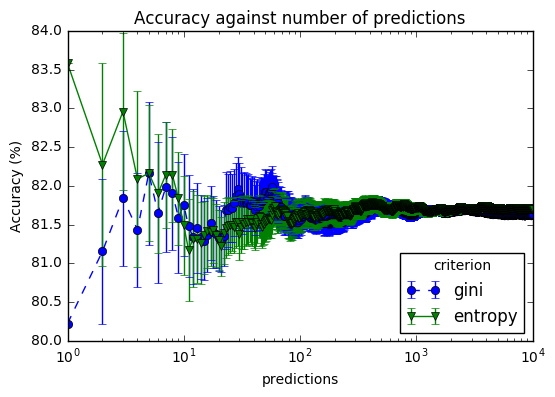

In [33]:
#plot the accuracy with error against the number of fits
plt.errorbar(np.arange(1, len(acc_av_g)+1), acc_av_g, 
                 yerr = err_acc_g, marker="o", label="gini", ls='dashed')
plt.errorbar(np.arange(1, len(acc_av_e)+1), acc_av_e, 
                 yerr = err_acc_e, marker="v", label="entropy", ls='solid')
plt.title("Accuracy against number of predictions")
plt.xlabel("predictions")
plt.ylabel("Accuracy (%)")
plt.xscale('log')
plt.legend(loc='lower right', title="criterion");
plt.show()

They both converge to a value that is very close.

Now we look at the distributions of accuracies

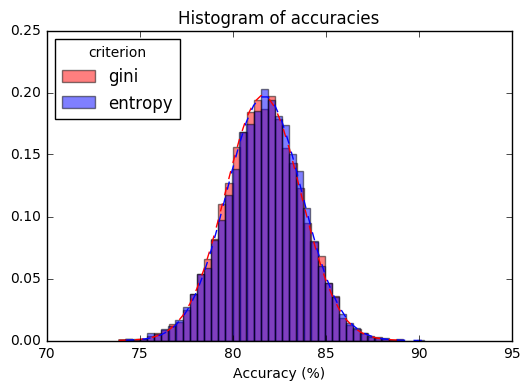

criterion     mean          std
gini:         81.6375746269 2.01721305697
entropy:      81.7040671642 2.02199576213


In [34]:
#plot the distribution of accuracies
n_g = np.int(np.floor(acc_g.max()/100.0*0.3*df_train.shape[0]-acc_g.min()/100.0*0.3*df_train.shape[0]))
mu_g = acc_g.mean()
sigma_g = acc_g.std()
n_e = np.int(np.floor(acc_e.max()/100.0*0.3*df_train.shape[0]-acc_e.min()/100.0*0.3*df_train.shape[0]))
mu_e = acc_e.mean()
sigma_e = acc_e.std()

n, bins_g, patches = plt.hist(acc_g,n_g, normed = 1,  color='red', alpha = 0.5, label='gini')
y_g = mlab.normpdf( bins_g, mu_g, sigma_g)
l = plt.plot(bins_g, y_g, 'r--', linewidth=1,  color='red')
n, bins_e, patches = plt.hist(acc_e,n_e, normed = 1,  color='blue', alpha = 0.5, label='entropy')
y_e = mlab.normpdf( bins_e, mu_e, sigma_e)
l = plt.plot(bins_e, y_e, 'r--', linewidth=1,  color='blue')
plt.title("Histogram of accuracies")
plt.xlabel("P(Acc)")
plt.xlabel("Accuracy (%)")
plt.legend(loc='upper left',title="criterion");
plt.show()
print('criterion     mean          std')
print('gini:        ', mu_g, sigma_g)
print('entropy:     ', mu_e, sigma_e)

The values are very close, with entropy giving a slightly higher accuracy. We hypothesize that the results come from the same distribution and that they give the same mean and same standard deviation (i.e. there is no difference between using gini or entropy).

We will test this hypothesis by calculating the p-value for the differences in the means and in the standard deviations. To do this, we will merge the distributions, permutate them, split them back into separate distributions, and calculate the differences in the means and stds between the two distributions. The p value is then the probability of finding the difference in the mean (or std) that we observed above or a more extreme result. We will class the difference in the means (or std) as statistically significant if the p value is less than 5%.

(Note: The difference between the mean accuracies for the methods is so small (roughly ~0.1%) that it doesn't much matter either way which one we use, but still, lets check if the difference is statistically significant, even if it is not practially significant).

In [35]:
org_diff_mean = acc_g.mean()-acc_e.mean()
org_diff_std = acc_g.std()-acc_e.std()
#Concatonate the data
acc_concat = np.concatenate((acc_g, acc_e))
n = 1000000
diffs_mean = np.empty(n)
diffs_std = np.empty(n)
for i in range(n):
    #take a permutation
    acc_permutation = np.random.permutation(acc_concat)
    #split the permuted data into two
    acc_perm_1 = acc_permutation[:len(acc_g)]
    acc_perm_2 = acc_permutation[len(acc_g):]
    #take the difference in the means and stds, store in diffs
    diffs_mean[i]=acc_perm_2.mean() - acc_perm_1.mean()
    diffs_std[i]=acc_perm_2.std() - acc_perm_1.std()
    
if org_diff_mean > diffs_mean.mean():    
    p_mean = np.sum(diffs_mean > org_diff_mean)/len(diffs_mean)
else:
    p_mean = np.sum(diffs_mean < org_diff_mean)/len(diffs_mean)
    
if org_diff_std > diffs_std.mean():    
    p_std = np.sum(diffs_std > org_diff_std)/len(diffs_std)
else:
    p_std = np.sum(diffs_std < org_diff_std)/len(diffs_std)
    
print('#p value - mean:', p_mean*200.0)
print('#p value - std: ', p_std*200.0)

#p value - mean: 2.0158
#p value - std:  81.582


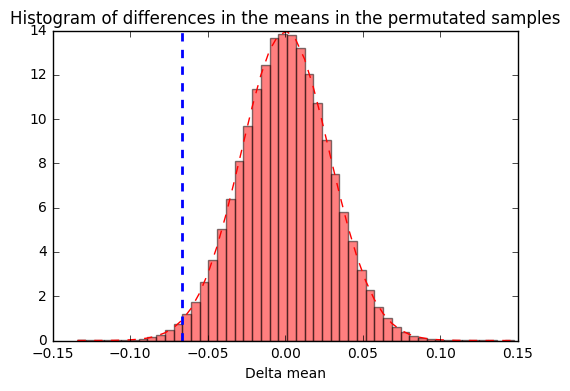

mu:          5.63967910448e-05
sigma:       0.0285669490315
empirical:   -0.0664925373134
empir/sigma: 2.32760373675


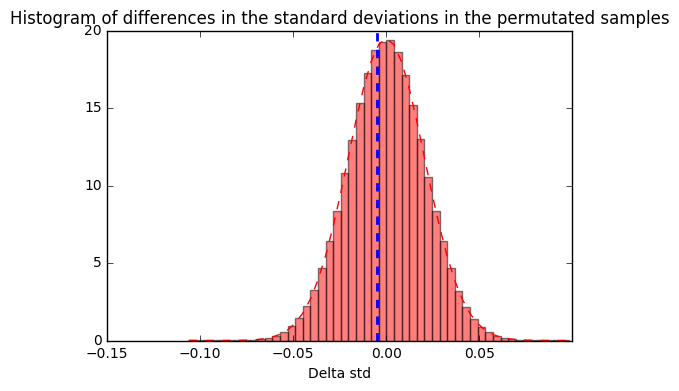

mu:          -6.60862779983e-06
sigma:       0.0204775904729
empirical:   -0.00478270515543
empir/sigma: 0.233558003896


In [36]:
#plot the distribution of accuracies
n = 50
mu = diffs_mean.mean()
sigma = diffs_mean.std()
nn, bins, patches = plt.hist(diffs_mean,n, normed = 1,  color='red', alpha = 0.5)
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1,  color='red')
plt.axvline(org_diff_mean, color='b', linestyle='dashed', linewidth=2)
plt.title("Histogram of differences in the means in the permutated samples")
plt.xlabel("P(Delta mean)")
plt.xlabel("Delta mean")
plt.show()

print('mu:         ', mu)
print('sigma:      ', sigma)
print('empirical:  ', org_diff_mean)
print('empir/sigma:', np.absolute(org_diff_mean/sigma))

n = 50
mu = diffs_std.mean()
sigma = diffs_std.std()
nn, bins, patches = plt.hist(diffs_std,n, normed = 1,  color='red', alpha = 0.5)
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1,  color='red')
plt.axvline(org_diff_std, color='b', linestyle='dashed', linewidth=2)
plt.title("Histogram of differences in the standard deviations in the permutated samples")
plt.xlabel("P(Delta std)")
plt.xlabel("Delta std")
plt.show()

print('mu:         ', mu)
print('sigma:      ', sigma)
print('empirical:  ', org_diff_std)
print('empir/sigma:', np.absolute(org_diff_std/sigma))

 - The p value for the difference in the means is small, less about 2% (i.e. the difference we measured between the mean falls outisde the 95% confidence inteval (over 2 stds from the distribution peak)), so we can discount the hypothesis that gini and entropy give the same results.
 - For the difference in the standard deviations, our p value is very large, as the difference we measured between the standard deviations is (much) less than 1 std from the distribution peak, so we definately cannot discount the hypothesis. 
 
So entropy gives a mean accuracy which is larger than using gini, and the result is statistically significant. The standard deviations are, for all intents and purposes, the same, meaning that the spread in results for both methods is the same, and they are likely to converge at the same rate.

Overall, there is very little difference between the two, entropy wins by a smidgen, and since speed is not king for this project (the data set is tiny), we will use entropy.

Now we will look at whether we bootstrap samples to build the trees or not

In [39]:
#see how the error scales
features = df_train.columns[df_train.columns != "Survived"].tolist()
n_loop = 1000  #this will be slow to run: can probably do 2500
acc_b = np.empty(n_loop)
acc_av_b = np.empty(n_loop)
err_acc_b = np.empty(n_loop)
acc_nb = np.empty(n_loop)
acc_av_nb = np.empty(n_loop)
err_acc_nb = np.empty(n_loop)

cls_report_b_sum = pd.DataFrame({'f1_score' : [0,0,0], 'precision' : [0,0,0], 
                               'recall' : [0,0,0], 'support' : [0,0,0]}, 
                              index=['Perished', 'Survived', 'Avg'])
cls_report_nb_sum = pd.DataFrame({'f1_score' : [0,0,0], 'precision' : [0,0,0], 
                               'recall' : [0,0,0], 'support' : [0,0,0]}, 
                              index=['Perished', 'Survived', 'Avg'])

print('  i    bs        +/-     nbs     +/-' )


for i in np.arange(0,n_loop):
    #with gini
    rf = RandomForestClassifier(criterion = 'entropy', bootstrap=True)
    res, acc_b[i], cls_report_b = train_model(df_train, df_test, rf, features, 'Survived', 0.3)
    acc_av_b[i] = acc_b[0:i+1].mean()
    cls_report_b_sum += classifaction_report_to_df(cls_report_b)
    #now with entropy
    rf = RandomForestClassifier(criterion = 'entropy', bootstrap=False)
    res, acc_nb[i], cls_report_nb = train_model(df_train, df_test, rf, features, 'Survived', 0.3)
    acc_av_nb[i] = acc_nb[0:i+1].mean()
    cls_report_nb_sum += classifaction_report_to_df(cls_report_nb)
    if i > 0:
        err_acc_b[i] = acc_b[0:i+1].std()/np.sqrt(i)
        err_acc_nb[i] = acc_nb[0:i+1].std()/np.sqrt(i)
    else:
        err_acc_b[i] = 0.0
        err_acc_nb[i] = 0.0
    if np.remainder(i+1,n_loop/20) == 0:
        print('{0:5d}  {1:.3f}  {2:.3f}  {3:.3f}  {4:.3f}'.format(
        i+1, acc_av_b[i], err_acc_b[i], acc_av_nb[i], err_acc_nb[i]))
    
print('')
print('Classification report (bootstrapping):')
print(cls_report_b_sum/float(n_loop))
print('')
print('Classification report (no bootstrapping):')
print(cls_report_nb_sum/float(n_loop))

  i    bs        +/-     nbs     +/-
   50  81.642  0.301  80.440  0.245
  100  81.858  0.208  80.537  0.193
  150  81.818  0.180  80.639  0.159
  200  81.903  0.157  80.632  0.140
  250  81.900  0.138  80.661  0.123
  300  81.831  0.125  80.657  0.113
  350  81.832  0.115  80.643  0.104
  400  81.854  0.107  80.686  0.097
  450  81.864  0.101  80.722  0.092
  500  81.804  0.095  80.749  0.088
  550  81.790  0.090  80.701  0.083
  600  81.826  0.086  80.670  0.080
  650  81.831  0.083  80.701  0.078
  700  81.837  0.080  80.730  0.075
  750  81.841  0.078  80.720  0.072
  800  81.811  0.076  80.720  0.070
  850  81.833  0.074  80.709  0.069
  900  81.844  0.072  80.727  0.067
  950  81.830  0.070  80.733  0.065
 1000  81.825  0.068  80.708  0.064

Classification report (bootstrapping):
          f1_score  precision   recall  support
Perished   0.85847    0.82630  0.89392   165.35
Survived   0.74538    0.80360  0.69731   102.65
Avg        0.81536    0.81856  0.81792   268.00

Classifica

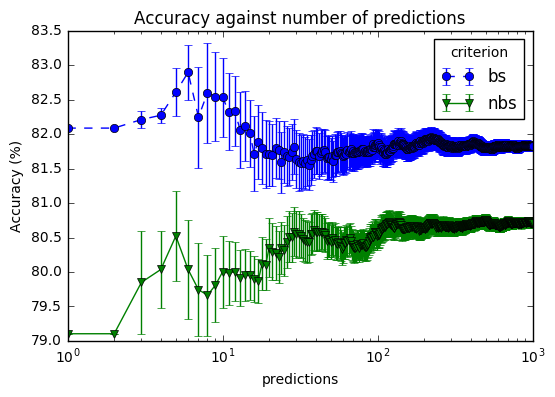

In [40]:
#plot the accuracy with error against the number of fits
plt.errorbar(np.arange(1, len(acc_av_b)+1), acc_av_b, 
                 yerr = err_acc_b, marker="o", label="bs", ls='dashed')
plt.errorbar(np.arange(1, len(acc_av_nb)+1), acc_av_nb, 
                 yerr = err_acc_nb, marker="v", label="nbs", ls='solid')
plt.title("Accuracy against number of predictions")
plt.xlabel("predictions")
plt.ylabel("Accuracy (%)")
plt.xscale('log')
plt.legend(loc='upper right', title="criterion");
plt.show()

Clearly bootstrapping is the way to go (and that is the default setting, so we can leave it be)
 
Now we look at the maximum depth of the tree

In [41]:
#now see how the score changes for different hyperparameters
features = df_train.columns[df_train.columns != "Survived"].tolist()
n_loop = 10000 #loops for each parameter
parameters_max_depth = 2**np.arange(0,11) #start on one and multiply by 2 each time
acc_av  = np.empty([len(parameters_max_depth)])
err_acc = np.empty([len(parameters_max_depth)])

i1 = -1
for max_depth in parameters_max_depth:
    i1 += 1
    acc_sum = 0.0
    accsq_sum = 0.0
    for i in range(n_loop):
        rf = RandomForestClassifier(max_depth=max_depth, criterion = 'entropy')
        res, acc, cls_report = train_model(df_train, df_test, rf, features, 'Survived', 0.3)
        acc_sum += acc
        accsq_sum += acc**2
    acc_av[i1] = acc_sum/float(n_loop)
    err_acc[i1] = ((accsq_sum/float(n_loop) - acc_av[i1]**2)/float(n_loop-1))**0.5
    print('max_depth:', max_depth, 'Acc:', acc_av[i1], '+/-', err_acc[i1])

max_depth: 1 Acc: 74.5725746269 +/- 0.0418481599416
max_depth: 2 Acc: 78.844141791 +/- 0.0307815060448
max_depth: 4 Acc: 81.9670149254 +/- 0.0228633345343
max_depth: 8 Acc: 82.5217910448 +/- 0.0204586920926
max_depth: 16 Acc: 81.7381716418 +/- 0.0202615203287
max_depth: 32 Acc: 81.7211567164 +/- 0.0205212901286
max_depth: 64 Acc: 81.7165671642 +/- 0.0204276636782
max_depth: 128 Acc: 81.700261194 +/- 0.020176097681
max_depth: 256 Acc: 81.7193656716 +/- 0.0203765577707
max_depth: 512 Acc: 81.7260820896 +/- 0.0204759449088
max_depth: 1024 Acc: 81.7079477612 +/- 0.0202813315801


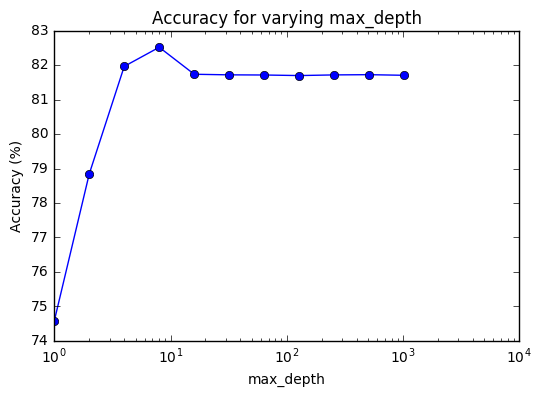

In [42]:
plt.errorbar(parameters_max_depth, acc_av, 
             yerr = err_acc, marker="o")
plt.title("Accuracy for varying max_depth")
plt.xlabel("max_depth")
plt.ylabel("Accuracy (%)")
plt.xscale('log')
plt.show()

There is a slight peak between 4 and about 12. We will now zoom in on this region

In [43]:
#now see how the score changes for different hyperparameters
features = df_train.columns[df_train.columns != "Survived"].tolist()
n_loop = 10000 #loops for each parameter
parameters_max_depth = np.arange(4,13)
acc_av  = np.empty([len(parameters_max_depth)])
err_acc = np.empty([len(parameters_max_depth)])

i1 = -1
for max_depth in parameters_max_depth:
    i1 += 1
    acc_sum = 0.0
    accsq_sum = 0.0
    for i in range(n_loop):
        rf = RandomForestClassifier(max_depth=max_depth, criterion = 'entropy')
        res, acc, cls_report = train_model(df_train, df_test, rf, features, 'Survived', 0.3)
        acc_sum += acc
        accsq_sum += acc**2
    acc_av[i1] = acc_sum/float(n_loop)
    err_acc[i1] = ((accsq_sum/float(n_loop) - acc_av[i1]**2)/float(n_loop-1))**0.5
    print('max_depth:', max_depth, 'Acc:', acc_av[i1], '+/-', err_acc[i1])

max_depth: 4 Acc: 81.9942537313 +/- 0.0224906863968
max_depth: 5 Acc: 82.4059701493 +/- 0.0211753374817
max_depth: 6 Acc: 82.4854104478 +/- 0.020093375753
max_depth: 7 Acc: 82.5448880597 +/- 0.0202590003766
max_depth: 8 Acc: 82.4680223881 +/- 0.0204586873521
max_depth: 9 Acc: 82.4443656716 +/- 0.0203029138912
max_depth: 10 Acc: 82.3827985075 +/- 0.0205362538909
max_depth: 11 Acc: 82.2440298507 +/- 0.0205169013636
max_depth: 12 Acc: 82.1109328358 +/- 0.0204485850662


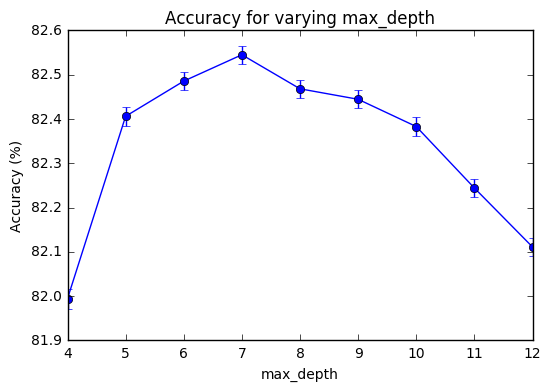

In [44]:
plt.errorbar(parameters_max_depth, acc_av, 
             yerr = err_acc, marker="o")
plt.title("Accuracy for varying max_depth")
plt.xlabel("max_depth")
plt.ylabel("Accuracy (%)")
plt.show()

Looks like it peaks on 7, it could be 6 or maybe 8 (they are roughly within the error bars of each other), but we will go with 7

Now we do the same for min_samples_split

In [45]:
#now see how the score changes for different hyperparameters
features = df_train.columns[df_train.columns != "Survived"].tolist()
n_loop = 20000 #loops for each parameter
parameters_min_samples_split = np.arange(2,21)
acc_av  = np.empty([len(parameters_min_samples_split)])
err_acc = np.empty([len(parameters_min_samples_split)])

i1 = -1
for min_samples_split in parameters_min_samples_split:
    i1 += 1
    acc_sum = 0.0
    accsq_sum = 0.0
    for i in range(n_loop):
        rf = RandomForestClassifier(min_samples_split=min_samples_split, max_depth=7,criterion = 'entropy')
        res, acc, cls_report = train_model(df_train, df_test, rf, features, 'Survived', 0.3)
        acc_sum += acc
        accsq_sum += acc**2
    acc_av[i1] = acc_sum/float(n_loop)
    err_acc[i1] = ((accsq_sum/float(n_loop) - acc_av[i1]**2)/float(n_loop-1))**0.5
    print('min_samples_split:', min_samples_split, 'Acc:', acc_av[i1], '+/-', err_acc[i1])

min_samples_split: 2 Acc: 82.5144776119 +/- 0.0143106149528
min_samples_split: 3 Acc: 82.5419589552 +/- 0.0143357390888
min_samples_split: 4 Acc: 82.5492350746 +/- 0.0143226051901
min_samples_split: 5 Acc: 82.6005783582 +/- 0.0143797101255
min_samples_split: 6 Acc: 82.6236567164 +/- 0.0143213765536
min_samples_split: 7 Acc: 82.614738806 +/- 0.0143563945816
min_samples_split: 8 Acc: 82.6016231343 +/- 0.0142703681428
min_samples_split: 9 Acc: 82.6224067164 +/- 0.0143602200152
min_samples_split: 10 Acc: 82.618358209 +/- 0.0143970467822
min_samples_split: 11 Acc: 82.6445895522 +/- 0.0142767912701
min_samples_split: 12 Acc: 82.6406156716 +/- 0.0143963020631
min_samples_split: 13 Acc: 82.6344216418 +/- 0.0144120958967
min_samples_split: 14 Acc: 82.6239925373 +/- 0.0143368078427
min_samples_split: 15 Acc: 82.6213619403 +/- 0.0143636105946
min_samples_split: 16 Acc: 82.6099440299 +/- 0.0144010252431
min_samples_split: 17 Acc: 82.6420335821 +/- 0.0144016837006
min_samples_split: 18 Acc: 82.6460

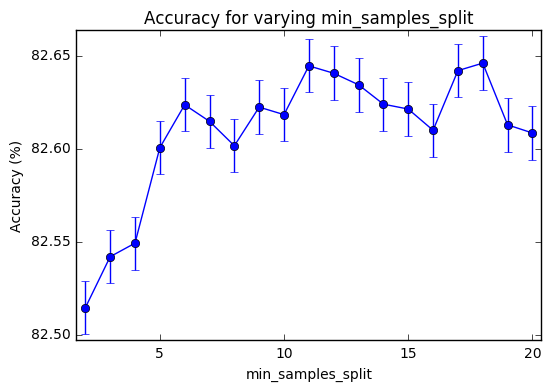

In [47]:
plt.errorbar(parameters_min_samples_split, acc_av, 
             yerr = err_acc, marker="o")
plt.title("Accuracy for varying min_samples_split")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy (%)")
plt.margins(0.02)
plt.show()

The values are all virtually the same and we don't really gain anything, but lets go with the "peak" value of 12.

Now we do the same for n_estimators. Here we will make use of the warm_start feature, where the model will fit to our data, then simply add more estimators to the ensemble.

In [48]:
#now see how the score changes for different hyperparameters
features = df_train.columns[df_train.columns != "Survived"].tolist()
n_loop = 1000 #loops for each parameter
parameters_n_estimators = 2**np.arange(0,11) #start on one and multiply by 2 each time
acc_av  = np.empty([len(parameters_n_estimators)])
err_acc = np.empty([len(parameters_n_estimators)])
acc_sum = np.zeros([len(parameters_n_estimators)])
accsq_sum = np.zeros([len(parameters_n_estimators)])

for i in range(n_loop):
    rf = RandomForestClassifier(min_samples_split = 12, max_depth = 6, criterion = 'entropy', warm_start=True)
    train_features = df_train[features].values.reshape(-1,len(features))
    train_label    = df_train['Survived'].values.reshape(-1,)
    #split it into a training and a test set (split% to test)
    X_train, X_test, y_train, y_test = train_test_split(train_features, train_label, 
                                                    test_size=0.3)
    #now we need to scale the data, such that they have mean 0 and variance 1
    std_scale = preprocessing.StandardScaler().fit(X_train) #do this on the training data
    X_train  = std_scale.transform(X_train)
    X_test  = std_scale.transform(X_test)
    i1 = -1
    for n_estimators in parameters_n_estimators:
        i1 += 1
        rf.n_estimators=n_estimators 
        #fit the model
        rf.fit(X_train, y_train)
        #now find the accuracy on the test set (make it into a percentage)
        acc = rf.score(X_test, y_test)*100.0
        acc_sum[i1] += acc
        accsq_sum[i1] += acc**2
    if np.remainder(i+1,n_loop/20) == 0:
        print(100.0*float(i+1)/float(n_loop),'% complete')

for i1 in range(len(acc_av)):
    acc_av[i1] = acc_sum[i1]/float(n_loop)
    err_acc[i1] = ((accsq_sum[i1]/float(n_loop) - acc_av[i1]**2)/float(n_loop-1))**0.5
    print('n_estimators:', parameters_n_estimators[i1], 'Acc:', acc_av[i1], '+/-', err_acc[i1])

5.0 % complete
10.0 % complete
15.0 % complete
20.0 % complete
25.0 % complete
30.0 % complete
35.0 % complete
40.0 % complete
45.0 % complete
50.0 % complete
55.0 % complete
60.0 % complete
65.0 % complete
70.0 % complete
75.0 % complete
80.0 % complete
85.0 % complete
90.0 % complete
95.0 % complete
100.0 % complete
n_estimators: 1 Acc: 78.0925373134 +/- 0.112932578808
n_estimators: 2 Acc: 79.8798507463 +/- 0.0839565029283
n_estimators: 4 Acc: 81.5108208955 +/- 0.0688323398949
n_estimators: 8 Acc: 82.4320895522 +/- 0.0644703660005
n_estimators: 16 Acc: 82.846641791 +/- 0.063039497892
n_estimators: 32 Acc: 83.1029850746 +/- 0.0624945925442
n_estimators: 64 Acc: 83.1246268657 +/- 0.0616521622958
n_estimators: 128 Acc: 83.1779850746 +/- 0.0610446801862
n_estimators: 256 Acc: 83.1951492537 +/- 0.0615149142947
n_estimators: 512 Acc: 83.2190298507 +/- 0.0610243119034
n_estimators: 1024 Acc: 83.2115671642 +/- 0.0607618847382


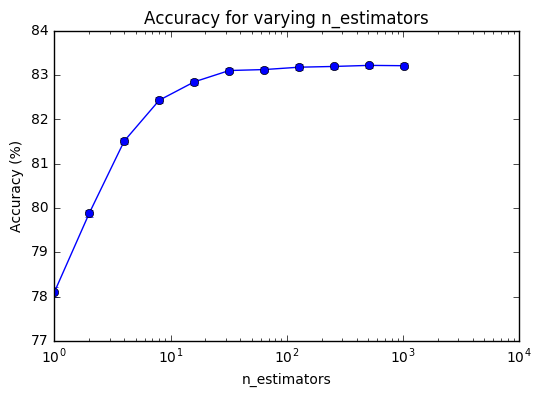

In [50]:
plt.errorbar(parameters_n_estimators, acc_av[:], 
             yerr = err_acc[:], marker="o")
plt.title("Accuracy for varying n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy (%)")
plt.xscale('log')
plt.show()

It seems to have converged above about 100, so anything above that is fine.
We will take 1000 for the final calculation.

And now we will do the same for the maximum number of features (max_features) and the minimum number of samples that required to be at a leaf node (min_samples_leaf). We will use 1000 n_estimators to speed this up.

In [51]:
#now see how the score changes for different hyperparameters
features = df_train.columns[df_train.columns != "Survived"].tolist()
n_loop = 1000 #loops for each set of params
parameters_max_features = np.arange(1,len(features)+1,1)
parameters_min_samples_leaf = np.arange(1,12,2)
acc_av   = np.empty([len(parameters_max_features), len(parameters_min_samples_leaf)])
err_acc_av   = np.empty([len(parameters_max_features), len(parameters_min_samples_leaf)])


i1 = -1
for max_features in parameters_max_features:
    i1 += 1
    i2 = -1
    for min_samples_leaf in parameters_min_samples_leaf:
        i2 += 1
        acc_sum = 0.0
        accsq_sum = 0.0
        for i in range(n_loop):
            rf = RandomForestClassifier(min_samples_split = 12, n_estimators=100, 
                                        max_depth=6, criterion = 'entropy',
                                        max_features=max_features, min_samples_leaf=min_samples_leaf)
            res, acc, cls_report = train_model(df_train, df_test, rf, features, 'Survived', 0.3)
            acc_sum += acc
            accsq_sum += acc**2
       
        acc_av[i1,i2] = acc_sum/float(n_loop)
        err_acc_av[i1,i2] = ((accsq_sum/float(n_loop) - acc_av[i1,i2]**2)/float(n_loop-1))**0.5
        print('max_features: ', max_features, ' min_samples_leaf: ', min_samples_leaf, 
              ' acc: ', acc_av[i1,i2], ' +/- ', err_acc_av[i1,i2])

max_features:  1  min_samples_leaf:  1  acc:  82.8313432836  +/-  0.0657446389814
max_features:  1  min_samples_leaf:  3  acc:  82.8541044776  +/-  0.0648726259254
max_features:  1  min_samples_leaf:  5  acc:  82.6708955224  +/-  0.0687870079229
max_features:  1  min_samples_leaf:  7  acc:  82.5552238806  +/-  0.0685270354451
max_features:  1  min_samples_leaf:  9  acc:  82.2361940299  +/-  0.0713859238333
max_features:  1  min_samples_leaf:  11  acc:  82.0361940299  +/-  0.0715847841027
max_features:  2  min_samples_leaf:  1  acc:  83.0757462687  +/-  0.0647984141139
max_features:  2  min_samples_leaf:  3  acc:  83.2171641791  +/-  0.0623250675261
max_features:  2  min_samples_leaf:  5  acc:  83.2268656716  +/-  0.0600312483373
max_features:  2  min_samples_leaf:  7  acc:  83.0555970149  +/-  0.0622182699974
max_features:  2  min_samples_leaf:  9  acc:  83.2410447761  +/-  0.0611615670541
max_features:  2  min_samples_leaf:  11  acc:  83.2097014925  +/-  0.0644192420404
max_features: 

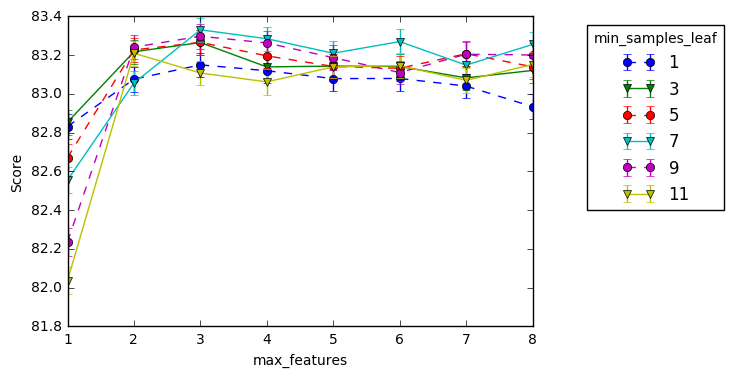

In [52]:
for i in np.arange(acc_av.shape[1]):
    if np.remainder(i,2) == 0:
        plt.errorbar(parameters_max_features, acc_av[:,i], 
                 yerr = err_acc_av[:,i], marker="o",  ls="dashed",
                 label=parameters_min_samples_leaf[i])
    else:
        plt.errorbar(parameters_max_features, acc_av[:,i], 
                 yerr = err_acc_av[:,i], marker="v",  ls="solid",
                 label=parameters_min_samples_leaf[i])    
    
    
plt.legend(loc='upper left', title="min_samples_leaf", bbox_to_anchor=(1.1, 1.0));
plt.xlabel("max_features")
plt.ylabel("Score")
plt.show()

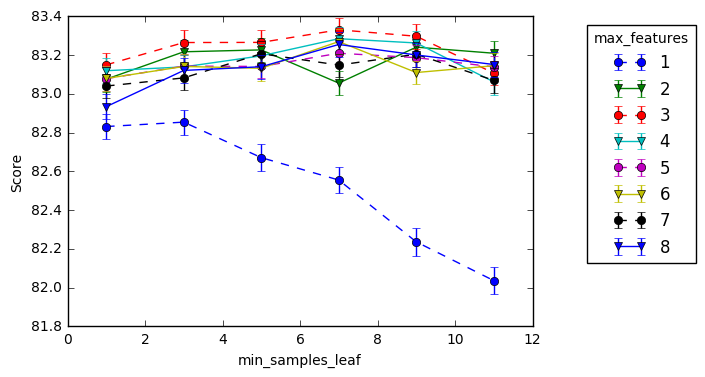

In [53]:
for i in np.arange(acc_av.shape[0]):
    if np.remainder(i,2) == 0:
        plt.errorbar(parameters_min_samples_leaf, acc_av[i,:], 
                 yerr = err_acc_av[i,:], marker="o", ls="dashed",
                 label=parameters_max_features[i])
    else:
        plt.errorbar(parameters_min_samples_leaf, acc_av[i,:], 
                 yerr = err_acc_av[i,:], marker="v", ls="solid",
                 label=parameters_max_features[i])

    
plt.legend(loc='upper left', title="max_features", bbox_to_anchor=(1.1, 1.0));
plt.xlabel("min_samples_leaf")
plt.ylabel("Score")
plt.show()

Clearly we don't want to use 1 or 6, 7 or 8 features. 3 seems to be the peak, then maybe 2. 

5 looks to be the best for min_samples_leaf, although again, from 3-9 looks quite similar.

We will now zoom in on these regions (2-3 features and 5-9 min_samples_leaf) and use more iterations to get a more accurate result.

In [54]:
#now see how the score changes for different hyperparameters
features = df_train.columns[df_train.columns != 'Survived'].tolist()
n_loop = 10000 #loops for each set of params
parameters_max_features = np.arange(2,4)
parameters_min_samples_leaf = np.arange(5,10)
acc_av   = np.empty([len(parameters_max_features), len(parameters_min_samples_leaf)])
err_acc_av   = np.empty([len(parameters_max_features), len(parameters_min_samples_leaf)])


i1 = -1
for max_features in parameters_max_features:
    i1 += 1
    i2 = -1
    for min_samples_leaf in parameters_min_samples_leaf:
        i2 += 1
        acc_sum = 0.0
        accsq_sum = 0.0
        for i in range(n_loop):
            rf = RandomForestClassifier(min_samples_split = 12, n_estimators=100, 
                                        max_depth=6, criterion = 'entropy',
                                        max_features=max_features, min_samples_leaf=min_samples_leaf)
            res, acc, cls_report = train_model(df_train, df_test, rf, features, 'Survived', 0.3)
            acc_sum += acc
            accsq_sum += acc**2
            if np.remainder(i+1,n_loop/10) == 0:
                print('loops:', i1, i2, '  complete: ', 100.0*float(i+1)/float(n_loop), '%')
       
        acc_av[i1,i2] = acc_sum/float(n_loop)
        err_acc_av[i1,i2] = ((accsq_sum/float(n_loop) - acc_av[i1,i2]**2)/float(n_loop-1))**0.5
        print('max_features: ', max_features, ' min_samples_leaf: ', min_samples_leaf, 
              ' acc: ', acc_av[i1,i2], ' +/- ', err_acc_av[i1,i2])
        print('')

loops: 0 0   complete:  10.0 %
loops: 0 0   complete:  20.0 %
loops: 0 0   complete:  30.0 %
loops: 0 0   complete:  40.0 %
loops: 0 0   complete:  50.0 %
loops: 0 0   complete:  60.0 %
loops: 0 0   complete:  70.0 %
loops: 0 0   complete:  80.0 %
loops: 0 0   complete:  90.0 %
loops: 0 0   complete:  100.0 %
max_features:  2  min_samples_leaf:  5  acc:  83.1914179104  +/-  0.0193553813818

loops: 0 1   complete:  10.0 %
loops: 0 1   complete:  20.0 %
loops: 0 1   complete:  30.0 %
loops: 0 1   complete:  40.0 %
loops: 0 1   complete:  50.0 %
loops: 0 1   complete:  60.0 %
loops: 0 1   complete:  70.0 %
loops: 0 1   complete:  80.0 %
loops: 0 1   complete:  90.0 %
loops: 0 1   complete:  100.0 %
max_features:  2  min_samples_leaf:  6  acc:  83.1786940299  +/-  0.0195347362545

loops: 0 2   complete:  10.0 %
loops: 0 2   complete:  20.0 %
loops: 0 2   complete:  30.0 %
loops: 0 2   complete:  40.0 %
loops: 0 2   complete:  50.0 %
loops: 0 2   complete:  60.0 %
loops: 0 2   complete:  70

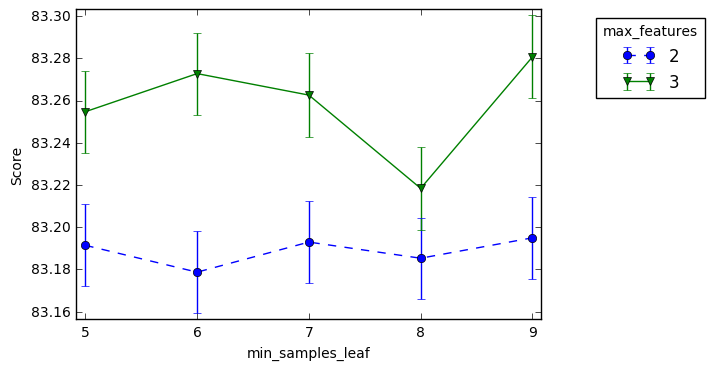

In [55]:
for i in np.arange(acc_av.shape[0]):
    if np.remainder(i,2) == 0:
        plt.errorbar(parameters_min_samples_leaf, acc_av[i,:], 
                 yerr = err_acc_av[i,:], marker="o", ls="dashed",
                 label=parameters_max_features[i])
    else:
        plt.errorbar(parameters_min_samples_leaf, acc_av[i,:], 
                 yerr = err_acc_av[i,:], marker="v", ls="solid",
                 label=parameters_max_features[i])

    
plt.legend(loc='upper left', title="max_features", bbox_to_anchor=(1.1, 1.0));
plt.xlabel("min_samples_leaf")
plt.ylabel("Score")
plt.margins(0.02)
plt.show()

We take 3 features and use 9 for min_samples_leaf.

Noe we train the model with our optimized parameters

In [65]:
#set the features
features = df_train.columns[df_train.columns != "Survived"].tolist()
#and the model
rf = RandomForestClassifier(n_estimators=1000, max_depth=7, criterion = 'entropy',
                            min_samples_split = 12, max_features=3, min_samples_leaf=9)
#how many times we fit the model
n_loop = 10000
#we will record the accuracy every time, so that we can plot it against the n_loop later
acc = np.empty(n_loop)
acc_av = np.empty(n_loop)
err_acc = np.empty(n_loop)
#and we will make an empty array for the feature importances
importance = np.empty([n_loop, len(features)])
#and we will sum up the predictions for the test set
res_sum = 0.0
cls_report_sum = pd.DataFrame({'f1_score' : [0,0,0], 'precision' : [0,0,0], 
                               'recall' : [0,0,0], 'support' : [0,0,0]}, 
                              index=['Perished', 'Survived', 'Avg'])
      
print('  i    train   +/-' )

for i in np.arange(0,n_loop):
    res, acc[i], cls_report = train_model(df_train, df_test, rf, features, 'Survived', 0.3)
    acc_av[i] = acc[0:i+1].mean()
    res_sum += res
    cls_report_sum += classifaction_report_to_df(cls_report)
    if i > 0:
        err_acc[i] = acc[0:i+1].std()/np.sqrt(i)
    else:
        err_acc[i] = 0.0
    importance[i,:] = rf.feature_importances_
    if np.remainder(i+1,n_loop/100) == 0:
        print('{0:5d}  {1:.3f}  {2:.3f}'.format(
            i+1, acc_av[i], err_acc[i]))
    
print('')
print('Classification report:')
print(cls_report_sum/float(n_loop))

  i    train   +/-
  100  83.261  0.206
  200  83.241  0.153
  300  83.264  0.118
  400  83.201  0.106
  500  83.278  0.094
  600  83.229  0.084
  700  83.219  0.078
  800  83.232  0.072
  900  83.252  0.068
 1000  83.278  0.064
 1100  83.289  0.060
 1200  83.290  0.058
 1300  83.297  0.056
 1400  83.290  0.054
 1500  83.277  0.052
 1600  83.302  0.050
 1700  83.311  0.048
 1800  83.317  0.047
 1900  83.340  0.046
 2000  83.336  0.045
 2100  83.351  0.044
 2200  83.357  0.043
 2300  83.349  0.042
 2400  83.337  0.041
 2500  83.335  0.040
 2600  83.330  0.039
 2700  83.328  0.039
 2800  83.331  0.038
 2900  83.331  0.037
 3000  83.335  0.036
 3100  83.331  0.036
 3200  83.335  0.035
 3300  83.339  0.034
 3400  83.334  0.034
 3500  83.336  0.033
 3600  83.341  0.033
 3700  83.334  0.033
 3800  83.334  0.032
 3900  83.345  0.032
 4000  83.350  0.031
 4100  83.361  0.031
 4200  83.361  0.030
 4300  83.358  0.030
 4400  83.351  0.030
 4500  83.347  0.029
 4600  83.343  0.029
 4700  83.341  

By tuning the parameters of the Random Forest model we have increased the accuracy by about 2%. We are still much better at predicting whether someone did not survive as opposed to if they did

Now we will output the results and submit to Kaggle

In [67]:
out_file = "results.csv"
output_result(np.rint(res_sum/float(n_loop)).astype(int), out_file)

This gives us an accuracy on the test data of 78.468%, almost 5% less than we found when we tested the model by splitting the training data.

Let's see where that fits on the distribution of accuracies we found

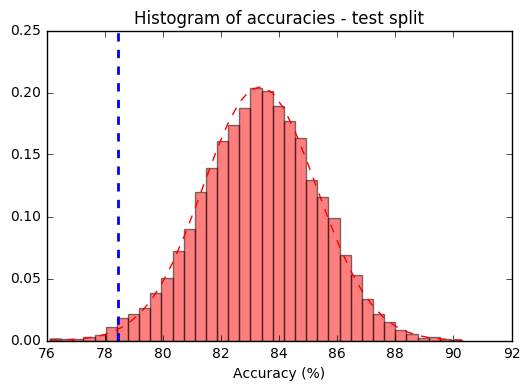

mean:      83.3344402985
s.d.:      1.94682464152
score:     78.468


In [60]:
#plot the distribution of accuracies
score = 78.468
#for the test split
n = np.int(np.floor(acc.max()/100.0*0.3*df_train.shape[0]-acc.min()/100.0*0.3*df_train.shape[0]))
mu = acc.mean()
sigma = acc.std()
n, bins, patches = plt.hist(acc,n, normed = 1,  color='red', alpha = 0.5)
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)
plt.axvline(score, color='b', linestyle='dashed', linewidth=2)
plt.title("Histogram of accuracies - test split")
plt.xlabel("P(Acc)")
plt.xlabel("Accuracy (%)")
plt.show()
print('mean:     ', mu)
print('s.d.:     ', sigma)
print('score:    ', score)


We are just outside our 95% confidence inteval (2 stds.)

Overall, we get a score of almost 80% on the unlabelled test data. Individual runs might give a few percent more, or they might give a few percent less, but by averaging over multiple runs, we average out the uncertainty.


We do one final loop of runs on the whole data set

In [61]:
#set the features
features = df_train.columns[df_train.columns != "Survived"].tolist()
#and the model
rf = RandomForestClassifier(n_estimators=1000, max_depth=7, criterion = 'entropy',
                            min_samples_split = 12, max_features=3, min_samples_leaf=9)
#how many times we fit the model
n_loop = 10000
#we will record the accuracy every time, so that we can plot it against the n_loop later
acc = np.empty(n_loop)
acc_av = np.empty(n_loop)
err_acc = np.empty(n_loop)
#and we will make an empty array for the feature importances
importance = np.empty([n_loop, len(features)])

#make the data into something that scikit learn can use
train_features = df_train[features].values.reshape(-1,len(features))
train_label    = df_train['Survived'].values.reshape(-1,)
test_features = df_test[features].values.reshape(-1,len(features))

#now we need to scale the data, such that they have mean 0 and variance 1
std_scale = preprocessing.StandardScaler().fit(train_features) #do this on the training data
train_features  = std_scale.transform(train_features)
test_features  = std_scale.transform(test_features)

res_sum = 0.0

for i in np.arange(0,n_loop):
    #fit the model
    rf.fit(train_features, train_label)
    res = rf.predict(test_features)
    res_sum += res
    if np.remainder(i+1,n_loop/20) == 0:
        print(i+1)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [64]:
out_file = "results.csv"
output_result(np.rint(res_sum/float(n_loop)).astype(int), out_file)

This gives us a final score of 79.904%